In [1]:
import pandas as pd

## Getting the dataset

In [2]:
df = pd.read_excel('song_dataset_lyrics1.xlsx')
df.head()

,artist,title,lyrics,genre,mood,year
0,Casual,I Didn't Mean To,Verse One:\r\n\r\nAlright I might\r\nHave had ...,Hip Hop/Rap,sad,1994
1,Adam Ant,Something Girls,Adam Ant/Marco Pirroni\r\nEvery girl is a some...,Rock,happy,1982
2,Gob,Face the Ashes,"I've just erased it's been a while, I've got a...",Rock,sad,2007
3,Lionel Richie,Tonight Will Be Alright,Little darling \r\nWhere you've been so long \...,R&B,happy,1986
4,Blue Rodeo,Floating,"Lead Vocal by Greg\r\n\r\nWell, these late nig...",Rock,sad,1987


In [3]:
from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np

## Label Encoder

In [4]:
X_train = df['lyrics'].values
y_train = df['mood'].values
print('before: %s ...' %y_train[:5])

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train[:5])

before: ['sad' 'happy' 'sad' 'happy' 'sad'] ...
after: [1 0 1 0 1] ...


In [5]:
pickle_out = open('./lyrics_label_encoder_py.pkl', 'wb')
pickle.dump(le, pickle_out)
pickle_out.close()

## Feature Extraction

### Porter Stemmer

In [6]:
# Porter Stemmer

import nltk
import string
import re

porter_stemmer = nltk.stem.porter.PorterStemmer()

def porter_tokenizer(text, stemmer=porter_stemmer):
    """
    A Porter-Stemmer-Tokenizer hybrid to splits sentences into words (tokens) 
    and applies the porter stemming algorithm to each of the obtained token. 
    Tokens that are only consisting of punctuation characters are removed as well.
    Only tokens that consist of more than one letter are being kept.
    
    Parameters
    ----------
        
    text : `str`. 
      A sentence that is to split into words.
        
    Returns
    ----------
    
    no_punct : `str`. 
      A list of tokens after stemming and removing Sentence punctuation patterns.
    
    """
    lower_txt = text.lower()
    tokens = nltk.wordpunct_tokenize(lower_txt)
    stems = [porter_stemmer.stem(t) for t in tokens]
    no_punct = [s for s in stems if re.match('^[a-zA-Z]+$', s) is not None]
    return no_punct

In [7]:
porter_tokenizer("Don't !!! --- want swimming. ")

['don', 't', 'want', 'swim']

In [8]:
with open('./stopwords.txt', 'r') as infile:
    stop_words = infile.read().splitlines()
print('stop words %s ...' %stop_words[:5])

stop words ['i', 'me', 'my', 'myself', 'we'] ...


### Count Vectorizer

In [9]:
# Count Vectorizer

from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=stop_words,
            tokenizer=porter_tokenizer,
            ngram_range=(1,1)
    )

In [10]:
vocab = ["123 1 The\n swimmer likes swimming so he swims. Don't didn`t"]

vec = vec.fit(vocab)

sentence1 = vec.transform([u'The swimmer likes swimming.'])
sentence2 = vec.transform(['The\nswimmer \nswims.'])


print('TEST:')
print('Vocabulary: %s' %vec.get_feature_names())
print('Sentence 1: %s' %sentence1.toarray())
print('Sentence 2: %s' %sentence2.toarray())


TEST:
Vocabulary: ['didn', 'like', 'swim', 'swimmer']
Sentence 1: [[0 1 1 1]]
Sentence 2: [[0 0 1 1]]


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=stop_words,
            tokenizer=porter_tokenizer
    )

In [12]:
vocab = ["123 1 The\n swimmer likes swimming so he swims. Don't didn`t"]

tfidf = tfidf.fit(vocab)

sentence1 = tfidf.transform([u'The swimmer likes swimming.'])
sentence2 = tfidf.transform(['The\nswimmer \nswims.'])


print('TEST:')
print('Vocabulary: %s' %tfidf.get_feature_names())
print('Sentence 1: %s' %sentence1.toarray())
print('Sentence 2: %s' %sentence2.toarray())

TEST:
Vocabulary: ['didn', 'like', 'swim', 'swimmer']
Sentence 1: [[0.         0.57735027 0.57735027 0.57735027]]
Sentence 2: [[0.         0.         0.70710678 0.70710678]]


### Fitting the lyrics

In [13]:
vec = vec.fit(X_train.ravel())
print('Vocabulary size: %s' %len(vec.get_feature_names()))

Vocabulary size: 8550


## Model Selection

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline

In [15]:
from sklearn import metrics

# `pos_label` for positive class, since we have sad=1, happy=0

f1_scorer = metrics.make_scorer(metrics.f1_score, greater_is_better=True, pos_label=0)

In [16]:
from sklearn.grid_search import GridSearchCV

pipeline_3 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

parameters_3 = dict(
    vect__binary=[False],
    vect__stop_words=[stop_words, None],
    vect__tokenizer=[porter_tokenizer, None],
    vect__ngram_range=[(1,1), (2,2), (3,3)],
)

grid_search_3 = GridSearchCV(pipeline_3, 
                           parameters_3, 
                           n_jobs=1, 
                           verbose=1,
                           scoring=f1_scorer,
                           cv=10
                )


print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_3.steps])
print("parameters:")
grid_search_3.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search_3.best_score_)
print("Best parameters set:")
best_parameters_3 = grid_search_3.best_estimator_.get_params()
for param_name in sorted(parameters_3.keys()):
    print("\t%s: %r" % (param_name, best_parameters_3[param_name]))

C:\Users\Samarth\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Samarth\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Performing grid search...
pipeline: ['vect', 'clf']
parameters:
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.6min finished


Best score: 0.620
Best parameters set:
	vect__binary: False
	vect__ngram_range: (1, 1)
	vect__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',

In [17]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")

#### Hyperparameter Tuning - max_features

#### Hyperparamter Tuning - min_df

#### Hyperparameter Tuning - alpha

#### n-gram Comparison

## Validation

In [18]:
final_clf = Pipeline([
                ('vect', CountVectorizer(
                                         binary=False,
                                         stop_words=stop_words,
                                         tokenizer=porter_tokenizer,
                                         ngram_range=(1,1),
                                         )
                ),
                ('clf', MultinomialNB(alpha=1.0)),
               ])
final_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['i', 'me',...50>,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

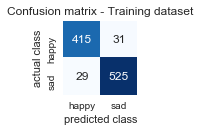

In [19]:
import matplotlib as mpl
import numpy as np
import seaborn as sns

cm = metrics.confusion_matrix(y_train, final_clf.predict(X_train))

np.set_printoptions(suppress=True)
mpl.rc("figure", figsize=(4, 2))

hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
plt.title('Confusion matrix - Training dataset')
plt.ylabel('actual class')
plt.xlabel('predicted class')
plt.tight_layout()
plt.show()

In [20]:

df = pd.read_excel('valid_songs_200.xlsx')

X_valid = df['lyrics'].values 
y_valid = df['mood'].values

y_valid = le.transform(y_valid)

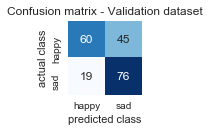

In [21]:
cm = metrics.confusion_matrix(y_valid, final_clf.predict(X_valid))

np.set_printoptions(suppress=True)
mpl.rc("figure", figsize=(4, 2))

hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
plt.title('Confusion matrix - Validation dataset')
plt.ylabel('actual class')
plt.xlabel('predicted class')
plt.tight_layout()
plt.show()

In [22]:
# Custom scorer methods to account for positive-negative class labels

from sklearn import metrics

# `pos_label` for positive class, since we have sad=1, happy=0

acc_scorer = metrics.make_scorer(metrics.accuracy_score, greater_is_better=True)
pre_scorer = metrics.make_scorer(metrics.precision_score, greater_is_better=True, pos_label=0)
rec_scorer = metrics.make_scorer(metrics.recall_score, greater_is_better=True, pos_label=0)
f1_scorer = metrics.make_scorer(metrics.f1_score, greater_is_better=True, pos_label=0)
auc_scorer = metrics.make_scorer(metrics.roc_auc_score, greater_is_better=True)

In [23]:
d = {'Data':['Training', 'Validation'],
     'ACC (%)':[],
     'PRE (%)':[],
     'REC (%)':[],
     'F1 (%)':[],
     'ROC AUC (%)':[],
}

In [24]:
d['ACC (%)'].append(acc_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['PRE (%)'].append(pre_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['REC (%)'].append(rec_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['F1 (%)'].append(f1_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['ROC AUC (%)'].append(auc_scorer(estimator=final_clf, X=X_train, y_true=y_train))

d['ACC (%)'].append(acc_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['PRE (%)'].append(pre_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['REC (%)'].append(rec_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['F1 (%)'].append(f1_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['ROC AUC (%)'].append(auc_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))

In [25]:
df_perform = pd.DataFrame(d)
df_perform = df_perform[['ACC (%)', 'PRE (%)', 'REC (%)', 'F1 (%)', 'ROC AUC (%)']]
df_perform.index=(['Training', 'Validation'])
df_perform = df_perform*100
df_perform = np.round(df_perform, decimals=2)
df_perform

,ACC (%),PRE (%),REC (%),F1 (%),ROC AUC (%)
Training,94.0,93.47,93.05,93.26,93.91
Validation,68.0,75.95,57.14,65.22,68.57


In [26]:
lyrics_clf_1000 = final_clf

pickle_out = open('./lyrics_clf_1000_py27.pkl', 'wb')
pickle.dump(lyrics_clf_1000, pickle_out)
pickle_out.close()